In [31]:
import torch
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

class MRNADataset(Dataset):
    def __init__(self, data_path, labels_path):
        # Load mRNA data and exclude the first column (patient IDs)
        mrna_data = pd.read_csv(data_path, header=0).iloc[:, 1:]

        # Remove columns with NaN values
        mrna_data = mrna_data.loc[:, ~mrna_data.isna().any()]

        # Convert to tensor
        self.mrna_data = torch.tensor(mrna_data.values, dtype=torch.float32)

        # Load survival binary labels
        self.labels = torch.tensor(pd.read_csv(labels_path)["SURVIVAL_BINARY"].values, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.mrna_data[idx], self.labels[idx]


# Example paths
data_path = "brca_metabric/dataset/mrna_zscores.csv"
labels_path = "brca_metabric/dataset/labels.csv"

# Create DataLoader
dataset = MRNADataset(data_path, labels_path)


# split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test DataLoader
for data, labels in dataloader:
    print(data.shape)  # Should match [batch_size, num_genes]
    print(labels.shape)  # Should match [batch_size]
    break


torch.Size([32, 20592])
torch.Size([32])


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertConfig, BertModel

# Model Definition
class DeepGeneTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, n_heads=4, n_layers=2):
        super(DeepGeneTransformer, self).__init__()
        
        # Transformer configuration
        self.embedding = nn.Linear(input_dim, hidden_dim)  # Map input_dim to hidden_dim
        self.transformer = nn.Transformer(
            d_model=hidden_dim, nhead=n_heads, num_encoder_layers=n_layers
        )
        
        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # Ensure x has shape (batch_size, seq_len, input_dim)
        x = self.embedding(x)  # (batch_size, seq_len, hidden_dim)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, hidden_dim)
        
        # Pass through transformer
        x = self.transformer(x, x)  # (seq_len, batch_size, hidden_dim)
        x = x.permute(1, 0, 2)  # Back to (batch_size, seq_len, hidden_dim)
        
        # Pooling to reduce seq_len dimension
        x = x.mean(dim=1)  # (batch_size, hidden_dim)
        
        # Fully connected layer
        x = self.fc(x)  # (batch_size, num_classes)
        return x

# Parameters
input_dim = 20592  # Example gene count
num_classes = 2    # Binary classification
batch_size = 32
num_samples = 500  # Number of samples in dummy dataset
hidden_dim = 128   # Transformer hidden dimension
epochs = 20

# Initialize Model
model = DeepGeneTransformer(input_dim=input_dim, num_classes=num_classes, hidden_dim=hidden_dim)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

# Training Loop with Validation
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=10):
    model.train()
    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train_samples = 0
        
        for batch in train_loader:
            data, labels = batch
            
            # Reshape data to (batch_size, seq_len, input_dim) for Transformer
            data = data.unsqueeze(1)  # Add seq_len dimension (batch_size, seq_len=1, input_dim)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            
            # Compute training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
        
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train_samples
        
        # Validation Phase
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val_samples = 0
        
        with torch.no_grad():
            for batch in val_loader:
                data, labels = batch
                
                # Reshape data to (batch_size, seq_len, input_dim)
                data = data.unsqueeze(1)
                
                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                
                # Compute validation accuracy
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)
        
        val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val_samples
        
        # Print epoch statistics
        print(
            f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
        )

# Generate Dummy Dataset
# Assuming input_dim is large, we'll use random tensors for simplicity.
torch.manual_seed(42)

# Train and Validate the Model
train_and_validate(model, dataloader, test_dataloader, optimizer, criterion, epochs)


C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/20 | Train Loss: 0.5468, Train Acc: 0.7443 | Val Loss: 0.4989, Val Acc: 0.7702
Epoch 2/20 | Train Loss: 0.4726, Train Acc: 0.7740 | Val Loss: 0.5401, Val Acc: 0.7424
Epoch 3/20 | Train Loss: 0.3538, Train Acc: 0.8554 | Val Loss: 0.6303, Val Acc: 0.7146
Epoch 4/20 | Train Loss: 0.2533, Train Acc: 0.9040 | Val Loss: 0.7424, Val Acc: 0.6970
Epoch 5/20 | Train Loss: 0.1509, Train Acc: 0.9527 | Val Loss: 0.8305, Val Acc: 0.7121
Epoch 6/20 | Train Loss: 0.0986, Train Acc: 0.9691 | Val Loss: 0.9662, Val Acc: 0.7071
Epoch 7/20 | Train Loss: 0.0979, Train Acc: 0.9653 | Val Loss: 0.9660, Val Acc: 0.7146
Epoch 8/20 | Train Loss: 0.0601, Train Acc: 0.9836 | Val Loss: 1.1546, Val Acc: 0.7020
Epoch 9/20 | Train Loss: 0.0461, Train Acc: 0.9855 | Val Loss: 1.1752, Val Acc: 0.7071
Epoch 10/20 | Train Loss: 0.0261, Train Acc: 0.9962 | Val Loss: 1.3385, Val Acc: 0.6818
Epoch 11/20 | Train Loss: 0.0602, Train Acc: 0.9836 | Val Loss: 1.2221, Val Acc: 0.7045
Epoch 12/20 | Train Loss: 0.0307, Train A

Test Loss: 1.3961
Pos to Neg ratio in test set: 3.2581
Predicted Pos to Neg ratio in test set: 3.5517
Accuracy: 0.7374
F1 Score: 0.8301
AUC: 0.6867
AUPRC: 0.8722
Precision: 0.8220
Recall: 0.8383
Specificity: 0.4086
MCC: 0.2528
Confusion Matrix: 
[[ 38  55]
 [ 49 254]]


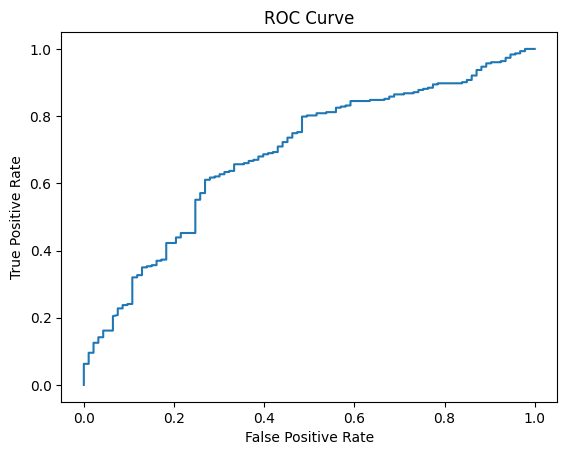

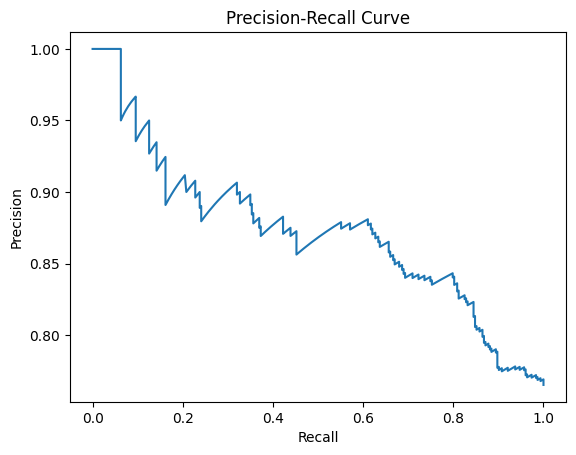

In [33]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix, matthews_corrcoef, average_precision_score, roc_curve, precision_recall_curve
)

import matplotlib.pyplot as plt

def calculate_metrics(all_labels, all_predictions, all_probs=None):
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    prec = precision_score(all_labels, all_predictions)
    rec = recall_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)
    mcc = matthews_corrcoef(all_labels, all_predictions)
    
    # For AUC and AUPRC, use probabilities if provided
    auc = roc_auc_score(all_labels, all_probs) if all_probs is not None else None
    auprc = average_precision_score(all_labels, all_probs) if all_probs is not None else None

    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # Specificity (negative class)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}" if auc is not None else "AUC: N/A")
    print(f"AUPRC: {auprc:.4f}" if auprc is not None else "AUPRC: N/A")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"MCC: {mcc:.4f}")
    print(f"Confusion Matrix: \n{cm}")

    # plot auc curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    # plot precision-recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def evaluate(model, dataloader, criterion):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []  # For AUC and AUPRC
    total_loss = 0
    
    with torch.no_grad():
        for batch in dataloader:
            data, labels = batch
            
            # Reshape data if necessary (comment out if not needed)
            data = data.unsqueeze(1)  # Add seq_len dimension if required
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Get softmax probabilities and predictions
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for positive class
            _, predictions = torch.max(outputs, dim=1)
            
            # Collect labels, predictions, and probabilities
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    print(f"Test Loss: {total_loss / len(dataloader):.4f}")
    print(f"Pos to Neg ratio in test set: {sum(all_labels)/(len(all_labels)-sum(all_labels)):.4f}")
    print(f"Predicted Pos to Neg ratio in test set: {sum(all_predictions)/(len(all_predictions)-sum(all_predictions)):.4f}")
    calculate_metrics(all_labels, all_predictions, all_probs)

# Evaluate the Model
evaluate(model, test_dataloader, criterion)
